# Elliptic++ Baseline Model

In [ ]:
!pip install torch
!pip install torch_geometric
!pip install faiss-cpu

## Data processing

In [5]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
import faiss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
import numpy as np
import random


# Load the dataset
df_txs_features = pd.read_csv('txs_features.csv')  # Load transaction features
df_txs_classes = pd.read_csv('txs_classes.csv')    # Load transaction classes
df_txs_edgelist = pd.read_csv('txs_edgelist.csv')  # Load edges (with transaction IDs)

# Clean features by dropping NaN values and reset the index
df_txs_features_clean = df_txs_features.dropna().reset_index(drop=True)

# Get the valid transaction IDs after cleaning
valid_transaction_ids = df_txs_features_clean['txId']

# Filter labels based on valid transaction IDs
labels_clean = df_txs_classes[df_txs_classes['txId'].isin(valid_transaction_ids)].reset_index(drop=True)

# Adjust labels to be zero-based
labels_clean = torch.tensor(labels_clean['class'].values - 1, dtype=torch.long)

# Filter edges based on valid transaction IDs
filtered_edges = df_txs_edgelist[
    (df_txs_edgelist['txId1'].isin(valid_transaction_ids)) & (df_txs_edgelist['txId2'].isin(valid_transaction_ids))
].reset_index(drop=True)

# Prepare tensors from the cleaned DataFrames
features_clean = torch.tensor(df_txs_features_clean.drop(columns=['txId']).values, dtype=torch.float32)

# Create edge_index tensor from filtered edges
edge_index_df = filtered_edges[['txId1', 'txId2']]  # Get the relevant columns as a DataFrame

# Create a mapping from transaction IDs to indices
id_to_index = {txId: index for index, txId in enumerate(valid_transaction_ids)}

# Map the edges to the new indices using the DataFrame values
edge_index = torch.tensor([[id_to_index[txId] for txId in edge_index_df['txId1']],
                            [id_to_index[txId] for txId in edge_index_df['txId2']]], dtype=torch.long)


In [6]:
# setting seeds
seed = 42 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark=False

## GCN Model creation

In [9]:
# Baseline GNN Model without ANN
class BaselineGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(BaselineGNN, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gat1 = GATConv(hidden_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # GCN Layer 1
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        # GAT Layer
        x = self.gat1(x, edge_index)
        x = F.relu(x)
        # GCN Layer 2 for output
        x = self.gcn2(x, edge_index)
        return x

# Initialize baseline model, optimizer, loss function, and scheduler
model = BaselineGNN(in_channels=features_clean.size(1), hidden_channels=64, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, threshold=1e-4, min_lr=5e-6)

# Train-test split
train_mask, test_mask = train_test_split(range(len(labels_clean)), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(features_clean, edge_index)  # Without ann_edge_index
    loss = criterion(out[train_mask], labels_clean[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
@torch.no_grad()
def test():
    model.eval()
    out = model(features_clean, edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[test_mask] == labels_clean[test_mask]).sum()
    acc = int(correct) / len(test_mask)
    return acc


In [ ]:
# Training Loop
num_epochs = 200
loss_history = []
accuracy_history = []

for epoch in range(1, num_epochs + 1):
    loss = train()
    loss_history.append(loss)

    if epoch % 10 == 0:
        test_acc = test()
        accuracy_history.append(test_acc)
        
        avg_loss = sum(loss_history[-10:]) / len(loss_history[-10:])  # Average loss for last 10 epochs
        print(f'Epoch: {epoch}, Avg Loss (last 10): {avg_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    else:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}')

    # Step the learning rate scheduler
    scheduler.step(avg_loss)
    print(f'lr: {scheduler.get_last_lr()}')


# Final Evaluation
final_test_acc = test()
print(f'Final Test Accuracy after {num_epochs} epochs: {final_test_acc:.4f}')



## Results

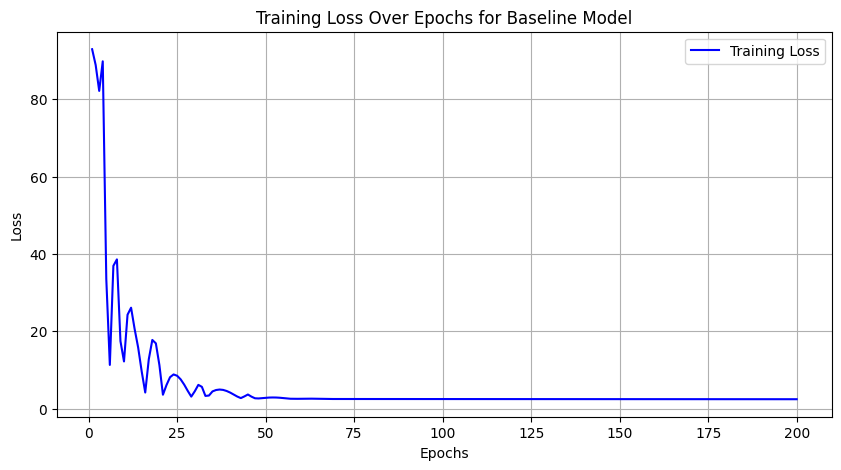

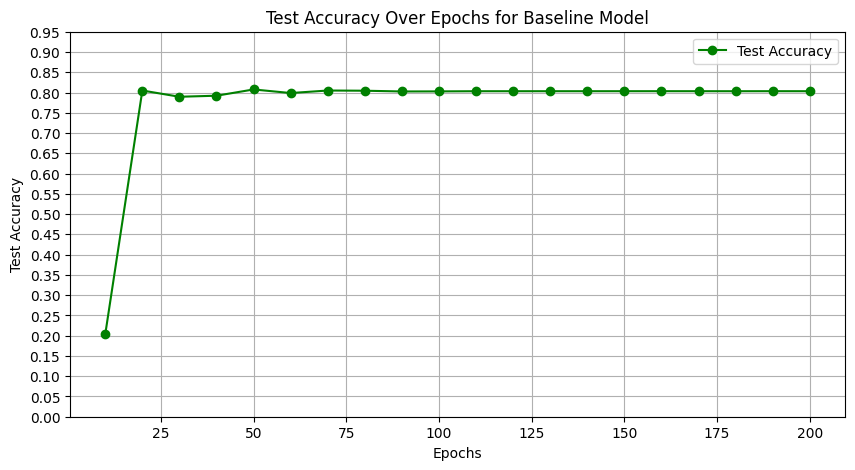

In [15]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history, color='blue', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for Baseline Model')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy history (captured every 10 epochs)
plt.figure(figsize=(10, 5))
plt.plot(range(10, num_epochs + 1, 10), accuracy_history, color='green', marker='o', linestyle='-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Over Epochs for Baseline Model')
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, 1, 0.05))
plt.show()